In [22]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import f1_score, accuracy_score
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sys
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load the train.csv file
train_df = pd.read_csv('train.csv')

# Preprocess the text in the train.csv file

sys.setrecursionlimit(100000)

stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

In [9]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase
    text = text.lower()
    # Remove stopwords and perform stemming
    text = [ps.stem(word) for word in text.split() if word not in stopwords]
    # Join the words back into a single string
    text = ' '.join(text)
    return text

In [11]:
train_df['comment_text'] = train_df['comment_text'].apply(clean_text)

# Tokenize the text and convert the labels to one-hot encoding
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['comment_text'])
X = tokenizer.texts_to_sequences(train_df['comment_text'])
X = pad_sequences(X, maxlen=200)
Y = train_df.iloc[:, 2:].values

# Define the LSTM model architecture
model = Sequential()
model.add(Embedding(max_features, 128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='sigmoid'))

# Compile the model and fit it on the training data
c_model = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
m_train = model.fit(X, Y, epochs=4, batch_size=256, validation_split=0.1)

Epoch 1/4
561/561 [==============================] - 1628s 3s/step - loss: 0.0899 - accuracy: 0.9594 - val_loss: 0.0566 - val_accuracy: 0.9940
Epoch 2/4
561/561 [==============================] - 1507s 3s/step - loss: 0.0489 - accuracy: 0.9942 - val_loss: 0.0523 - val_accuracy: 0.9939
Epoch 3/4
561/561 [==============================] - 1508s 3s/step - loss: 0.0451 - accuracy: 0.9936 - val_loss: 0.0550 - val_accuracy: 0.9940
Epoch 4/4
561/561 [==============================] - 1518s 3s/step - loss: 0.0417 - accuracy: 0.9941 - val_loss: 0.0526 - val_accuracy: 0.9922


In [ ]:
# Load the test.csv file
test_df = pd.read_csv('test.csv')

# Preprocess the text in the test.csv file
test_df['comment_text'] = test_df['comment_text'].apply(clean_text)

# Tokenize the text and predict the labels for each comment
X_test = tokenizer.texts_to_sequences(test_df['comment_text'])
X_test = pad_sequences(X_test, maxlen=200)
Y_test_pred = model.predict(X_test)

# Convert the predicted labels to binary (0 or 1)
Y_test_pred_binary = (Y_test_pred > 0.5).astype(int)

# Create a new DataFrame with the predicted labels
Y_test_pred_df = pd.DataFrame(Y_test_pred_binary, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
test_id_df = test_df['id']
test_result_df = pd.concat([Y_test_pred_df], axis=1)

# Save the predicted labels to a CSV file
test_result_df.to_csv('test_result.csv', index=False)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


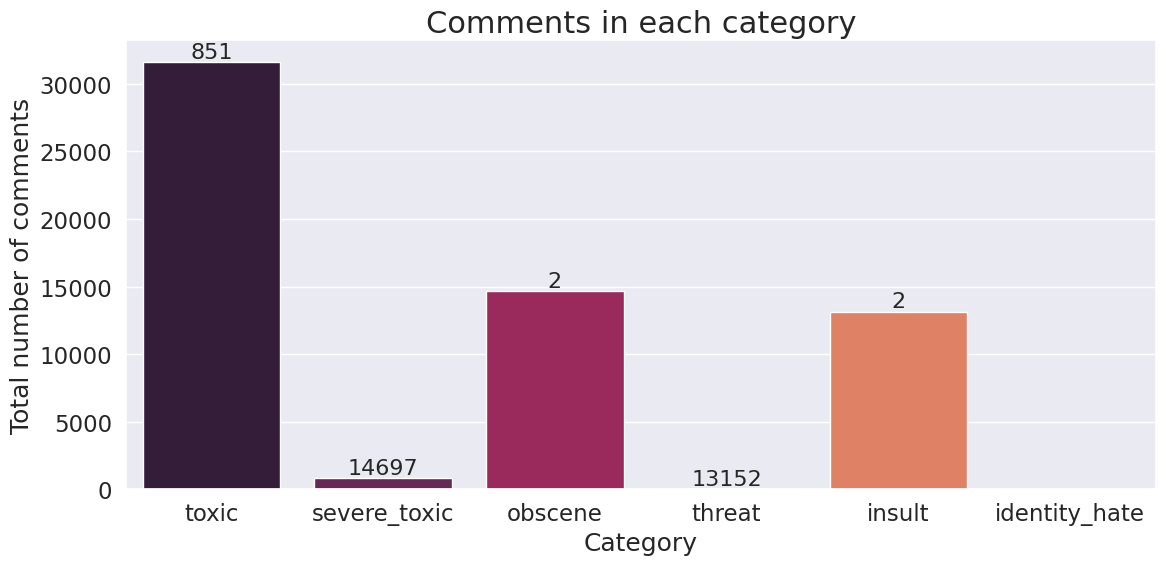

In [61]:
data_raw = pd.read_csv('test_result.csv')
categories = list(data_raw.columns.values)
categories = categories[1:]
print(categories)

# Set plot style and font size
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

# Create plot figure and axis object
fig, ax = plt.subplots(figsize=(12,6))

# Create bar plot
a = sns.barplot(x=categories, y=data_raw.iloc[:,1:].sum().values,palette="rocket")

# Set plot title and axis labels
ax.set_title("Comments in each category", fontsize=22)
ax.set_ylabel('Total number of comments', fontsize=18)
ax.set_xlabel('Category', fontsize=18)

# Add labels to the top of the bars
rects = a.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=16)

# Adjust spacing between subplots and save figure
plt.tight_layout()
plt.savefig('category_counts.png')

# Show plot
plt.show()


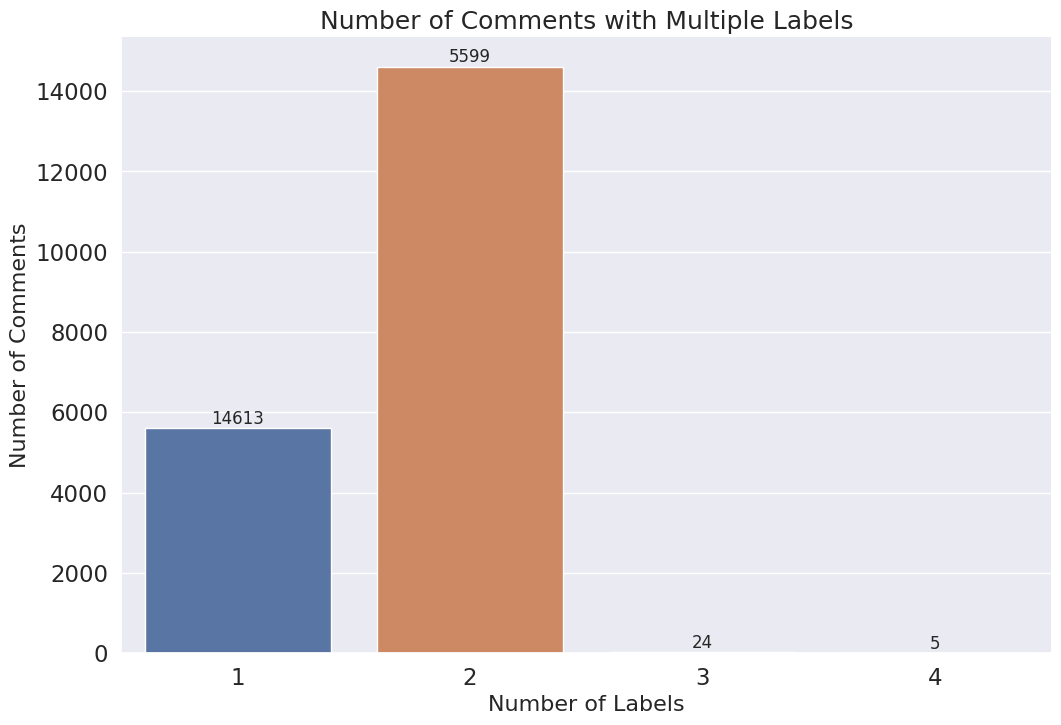

In [50]:
# Calculate the number of labels for each comment
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multipleLabel_counts = rowSums.value_counts()
multipleLabel_counts = multipleLabel_counts.iloc[1:]

# Set the color palette and font size
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set(font_scale=1.5)

# Create a bar plot of the multiple label counts
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=multipleLabel_counts.index, y=multipleLabel_counts.values)

# Set the title and axis labels
plt.title("Number of Comments with Multiple Labels")
plt.ylabel("Number of Comments", fontsize=16)
plt.xlabel("Number of Labels", fontsize=16)

# Add the count labels above the bars
rects = ax.patches
labels = multipleLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

# Add horizontal grid lines
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine(top=True, right=True)

plt.show()

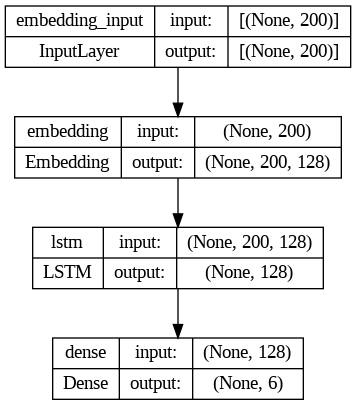

In [63]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)